In [1]:
!pip install bertopic

In [2]:
!pip install sentence-transformers

#**Loading the Data**

In [3]:
# Access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import pandas
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/grants.csv'
df = pd.read_csv(file_path)

# Display the first few rows
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Unnamed: 0,opportunity_id,opportunity_title,opportunity_number,opportunity_category,funding_instrument_type,category_of_funding_activity,cfda_numbers,eligible_applicants,eligible_applicants_type,...,post_date,close_date,last_updated_date,archive_date,award_ceiling,award_floor,estimated_total_program_funding,expected_number_of_awards,cost_sharing_or_matching_requirement,additional_information_url
0,0,262148,Establishment of the Edmund S. Muskie Graduate...,SCAPPD-14-AW-161-SCA-08152014,Discretionary,Cooperative Agreement,Other,19.040,Others,Non-Government Organization,...,2014-08-15,2014-09-04,2014-08-20,2014-10-04,600000.0,400000.0,600000.0,1.0,False,NaN
1,1,262308,Health and resiliency of salt marshes in Jamai...,NPS-14-NERO-0119,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-18,2014-08-23,2014-08-18,2014-08-24,275897.0,275897.0,275897.0,1.0,False,NaN
2,2,262368,Post-Hurricane Sandy submerged marine habitat ...,NPS-14-NERO-0125,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-19,2014-08-24,2014-08-19,2014-08-25,480000.0,480000.0,480000.0,1.0,False,NaN
3,3,262390,Inventory and Monitoring of Amphibians and Rep...,NPS-14-NERO-0087,Discretionary,Cooperative Agreement,Other,15.945,Others,Non-Government Organization,...,2014-08-19,2014-08-24,2014-08-19,2014-08-25,255577.0,255577.0,255577.0,1.0,False,NaN
4,4,131594,Youth Leadership Program with Algeria,ECA-PE-C-PY-12-09,Discretionary,Cooperative Agreement,Other,19.415,Others,Non-Government Organization,...,2011-11-21,2012-01-04,2011-11-21,2012-01-05,250000.0,NaN,250000.0,1.0,True,http://exchanges.state.gov/grants/open2.html


#**Preprocessing**

In [5]:
# Import the necessary modules
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing values in the relevant columns
df = df.dropna(subset=['opportunity_title', 'category_of_funding_activity'])

# Define the features and target
texts = df['opportunity_title'].astype(str).values
labels = df['category_of_funding_activity'].astype(str).values

# Tokenize and convert text to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure uniform input size
max_sequence_length = 150  # average title length
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Number of categories: {len(label_encoder.classes_)}")


Training samples: 60512, Testing samples: 15128
Number of categories: 26


#**RNN Model**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # Stop after 3 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# Define an improved model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length),
    LSTM(64, return_sequences=False),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.1971 - loss: 3.2072 - val_accuracy: 0.4211 - val_loss: 2.2033
Epoch 2/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.3990 - loss: 2.1602 - val_accuracy: 0.5216 - val_loss: 1.7596
Epoch 3/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5068 - loss: 1.7841 - val_accuracy: 0.5904 - val_loss: 1.5628
Epoch 4/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5802 - loss: 1.5749 - val_accuracy: 0.6150 - val_loss: 1.4497
Epoch 5/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6120 - loss: 1.4630 - val_accuracy: 0.6250 - val_loss: 1.3799
Epoch 6/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6374 - loss: 1.3606 - val_accuracy: 0.6277 - val_loss: 1.3345
Epoch 7/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6475 - loss: 1.2954 - val_accuracy: 0.6343 - val_loss: 1.3017
Epoch 8/15
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6586 - loss: 1

#**Visualize Training Progress**

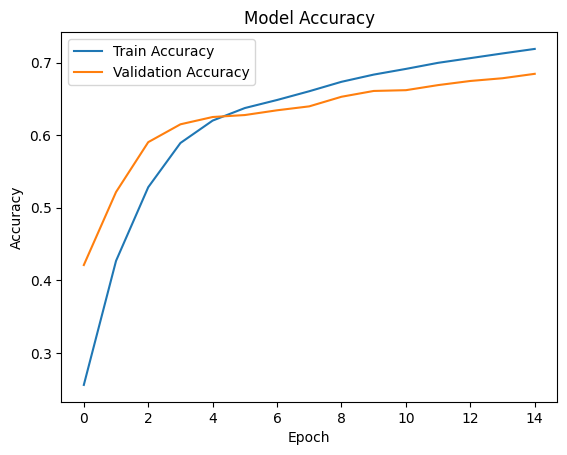

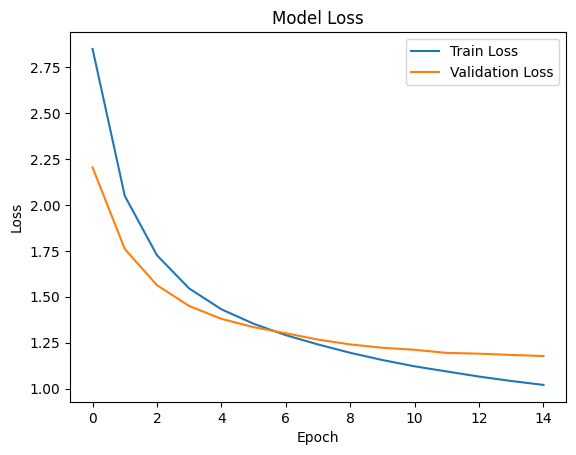

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


#**Evaluating the model**

In [8]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict on new data
sample_titles = ["Improving healthcare access in rural areas", "Climate resilience research funding"]
sample_sequences = tokenizer.texts_to_sequences(sample_titles)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length)
predictions = model.predict(sample_padded)
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

for title, category in zip(sample_titles, predicted_categories):
    print(f"Title: {title}\nPredicted Category: {category}\n")


473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6784 - loss: 1.1845
Test Loss: 1.1774, Test Accuracy: 0.6845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Title: Improving healthcare access in rural areas
Predicted Category: Health

Title: Climate resilience research funding
Predicted Category: Science and Technology and other Research and Development



#**Extended Evaluation**

In [9]:
# Define additional sample titles
sample_titles = [
    "Improving healthcare access in rural areas",
    "Climate resilience research funding",
    "Educational opportunities for underprivileged youth",
    "Research on renewable energy technologies",
    "Community safety and crime prevention programs",
    "Innovations in agricultural practices",
    "Advancements in artificial intelligence",
    "Support for small business development",
    "Ocean and marine life conservation projects",
    "Healthcare innovations for low-income communities"
]

# Tokenize and pad the sample titles
sample_sequences = tokenizer.texts_to_sequences(sample_titles)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length)

# Predict categories for the sample titles
predictions = model.predict(sample_padded)
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Display the results
for title, category in zip(sample_titles, predicted_categories):
    print(f"Title: {title}\nPredicted Category: {category}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Title: Improving healthcare access in rural areas
Predicted Category: Health

Title: Climate resilience research funding
Predicted Category: Science and Technology and other Research and Development

Title: Educational opportunities for underprivileged youth
Predicted Category: Education

Title: Research on renewable energy technologies
Predicted Category: Science and Technology and other Research and Development

Title: Community safety and crime prevention programs
Predicted Category: Law, Justice and Legal Services

Title: Innovations in agricultural practices
Predicted Category: Science and Technology and other Research and Development

Title: Advancements in artificial intelligence
Predicted Category: Science and Technology and other Research and Development

Title: Support for small business development
Predicted Category: Other

Title: Ocean and marine life conservation projects
Predicted Category: Science and Technology and other Research 

#**Validating Predictions Against Ground Truth**

In [10]:
from sklearn.metrics import classification_report, accuracy_score

# Generate predictions for the test dataset
test_predictions = model.predict(X_test)
predicted_indices = test_predictions.argmax(axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_indices)

# Convert ground truth labels (y_test) back to their category names
true_labels = label_encoder.inverse_transform(y_test)

# Compare predictions to ground truth
print("Validation Results:")
print(f"Accuracy: {accuracy_score(true_labels, predicted_labels):.4f}")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))


473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation Results:
Accuracy: 0.6845

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                           precision    recall  f1-score   support

                                      Affordable Care Act       0.00      0.00      0.00        22
                                              Agriculture       0.19      0.03      0.05       221
                                                     Arts       0.00      0.00      0.00        85
                                    Business and Commerce       0.00      0.00      0.00        78
                                    Community Development       0.00      0.00      0.00       161
                                      Consumer Protection       0.00      0.00      0.00         6
                           Disaster Prevention and Relief       0.00      0.00      0.00        63
                                                Education       0.63      0.62      0.62       825
                           Employment, Labor and Training       0.00      0.00      0.00       191
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#**Save Model**

In [11]:
# Save the model and tokenizer
model.save('rnn_funding_category_model_2.5.h5')

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


#**BERTopic Model**


In [27]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from IPython.display import display

# Load the dataset
file_path = '/content/drive/MyDrive/grants.csv'
df = pd.read_csv(file_path)
df = df.dropna(subset=['opportunity_title'])
df['opportunity_title'] = df['opportunity_title'].astype(str)

# Preprocess text by removing stopwords
custom_stopwords = set(["grant", "funding", "application"])
stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

def preprocess_text(text):
    return ' '.join([word for word in text.split() if word.lower() not in stopwords])

df['cleaned_opportunity_title'] = df['opportunity_title'].apply(preprocess_text)

# Define RNN categories
rnn_categories = label_encoder.classes_
print("RNN Categories:", rnn_categories)

# Initialize BERTopic with higher min_topic_size
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model, min_topic_size=400)

# Fit BERTopic
print("Fitting BERTopic to the dataset...")
topics, probs = topic_model.fit_transform(df['cleaned_opportunity_title'].values)

# Save topics and probabilities to the dataframe
df['topic'] = topics
df['topic_probability'] = probs

# Reduce topics to align better with RNN categories
topic_model.reduce_topics(df['cleaned_opportunity_title'], nr_topics=len(rnn_categories))

# Save the BERTopic model for reuse
topic_model.save("bertopic_model")
print("BERTopic model saved!")

# Visualize topics
print("Visualizing topics...")
barchart = topic_model.visualize_barchart(top_n_topics=len(rnn_categories))
display(barchart)

# Automated mapping using sentence embeddings
print("Mapping BERTopic topics to RNN categories...")
model = SentenceTransformer("all-MiniLM-L6-v2")
category_embeddings = model.encode(rnn_categories)

# Generate embeddings for reduced BERTopic keywords
topic_keywords = []
for topic_id in range(len(topic_model.get_topic_info())):
    keywords = topic_model.get_topic(topic_id)
    if keywords:
        topic_keywords.append(', '.join([word for word, _ in keywords]))
    else:
        topic_keywords.append('')

topic_embeddings = model.encode(topic_keywords)

# Map reduced topics to RNN categories using cosine similarity
mapped_categories = {}
for topic_id, topic_embedding in enumerate(topic_embeddings):
    if topic_keywords[topic_id] != "":
        similarities = util.cos_sim(topic_embedding, category_embeddings).squeeze()
        best_match = similarities.argmax().item()
        mapped_categories[topic_id] = rnn_categories[best_match]
    else:
        mapped_categories[topic_id] = "Other"

df['mapped_category'] = df['topic'].map(mapped_categories)

# Evaluate BERTopic performance
print("Evaluating BERTopic...")
true_labels = df['category_of_funding_activity'].astype(str)
predicted_labels = df['mapped_category'].astype(str)

print(f"Accuracy: {accuracy_score(true_labels, predicted_labels):.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# Save results to a CSV
df.to_csv('grants_with_topics.csv', index=False)
print("Results saved to grants_with_topics.csv")

# Example: Explore a specific topic
print("Details of Topic 0:")
print(topic_model.get_topic(0))


RNN Categories: ['Affordable Care Act' 'Agriculture' 'Arts' 'Business and Commerce'
 'Community Development' 'Consumer Protection'
 'Disaster Prevention and Relief' 'Education'
 'Employment, Labor and Training' 'Energy' 'Environment'
 'Food and Nutrition' 'Health' 'Housing' 'Humanities'
 'Income Security and Social Services' 'Information and Statistics'
 'Infrastructure Investment and Jobs Act'
 'Law, Justice and Legal Services' 'Natural Resources'
 'Opportunity Zone Benefits' 'Other' 'Recovery Act' 'Regional Development'
 'Science and Technology and other Research and Development'
 'Transportation']
Fitting BERTopic to the dataset...


2024-12-08 00:27:49,520 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


BERTopic model saved!
Visualizing topics...


Mapping BERTopic topics to RNN categories...
Evaluating BERTopic...
Accuracy: 0.2606

Classification Report:
                                                           precision    recall  f1-score   support

                                      Affordable Care Act       0.00      0.00      0.00        71
                                              Agriculture       0.00      0.00      0.00      1203
                                                     Arts       0.00      0.00      0.00       365
                                    Business and Commerce       0.00      0.00      0.00       426
                                    Community Development       0.00      0.00      0.00       705
                                      Consumer Protection       0.00      0.00      0.00        44
                           Disaster Prevention and Relief       0.00      0.00      0.00       332
                                                Education       0.15      0.22      0.18      4120

#**Final Compare and Contrast Analysis**

In [28]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0    0    0    4    0
     0    0    0    0   52    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    1  118    0    0    0  339   34    0
     0    0    3    0    4  127    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   30    0    0    0    0    1    0
     0    0    0    0    8   20    0    0    0    0    2    0]
 [   0    0    0    0    0    0    0   84    0    0    0    3    1    0
     0    0    0    0    0    5    0    0    0    0   11   18]
 [   0    0    0    0    0    0    6  210    0    0    0    2    9    0
     1    0    0    0   28   58    0    0    0    0    1    2]
 [   0    0    0    0    0    0    0    0    0    0    0    1    6    0
     0    0    0    0    2   13    0    0    0    0    1    2]
 [   0    0    0    0    0    0    0   26    3    0    0    8    4    0
     0    0    1    0    1   32    0    0    0    0    1    0]
 [   0    0    0    0    0    0    4

Matching Predictions: 1313
Mismatched Predictions: 13815

Examples of Matches:
                                    opportunity_title       rnn_category  \
11  Hurricane Sandy - Submerged Marine Habitat Map...  Natural Resources   
20  Notice of Intent to Award: The National Parks ...  Natural Resources   
38  Notice of Intent to Award: Implement River Man...  Natural Resources   
45  FY 2015 Special Professional Fellows Program f...          Education   
50    Hurricane Sandy - Natural Resource Data Manager  Natural Resources   

      mapped_category  
11  Natural Resources  
20  Natural Resources  
38  Natural Resources  
45          Education  
50  Natural Resources  

Examples of Mismatches:
                                   opportunity_title  \
0  Establishment of the Edmund S. Muskie Graduate...   
1  Health and resiliency of salt marshes in Jamai...   
2  Post-Hurricane Sandy submerged marine habitat ...   
3  Inventory and Monitoring of Amphibians and Rep...   
4              

<ipython-input-29-f56b4fa26877>:27: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



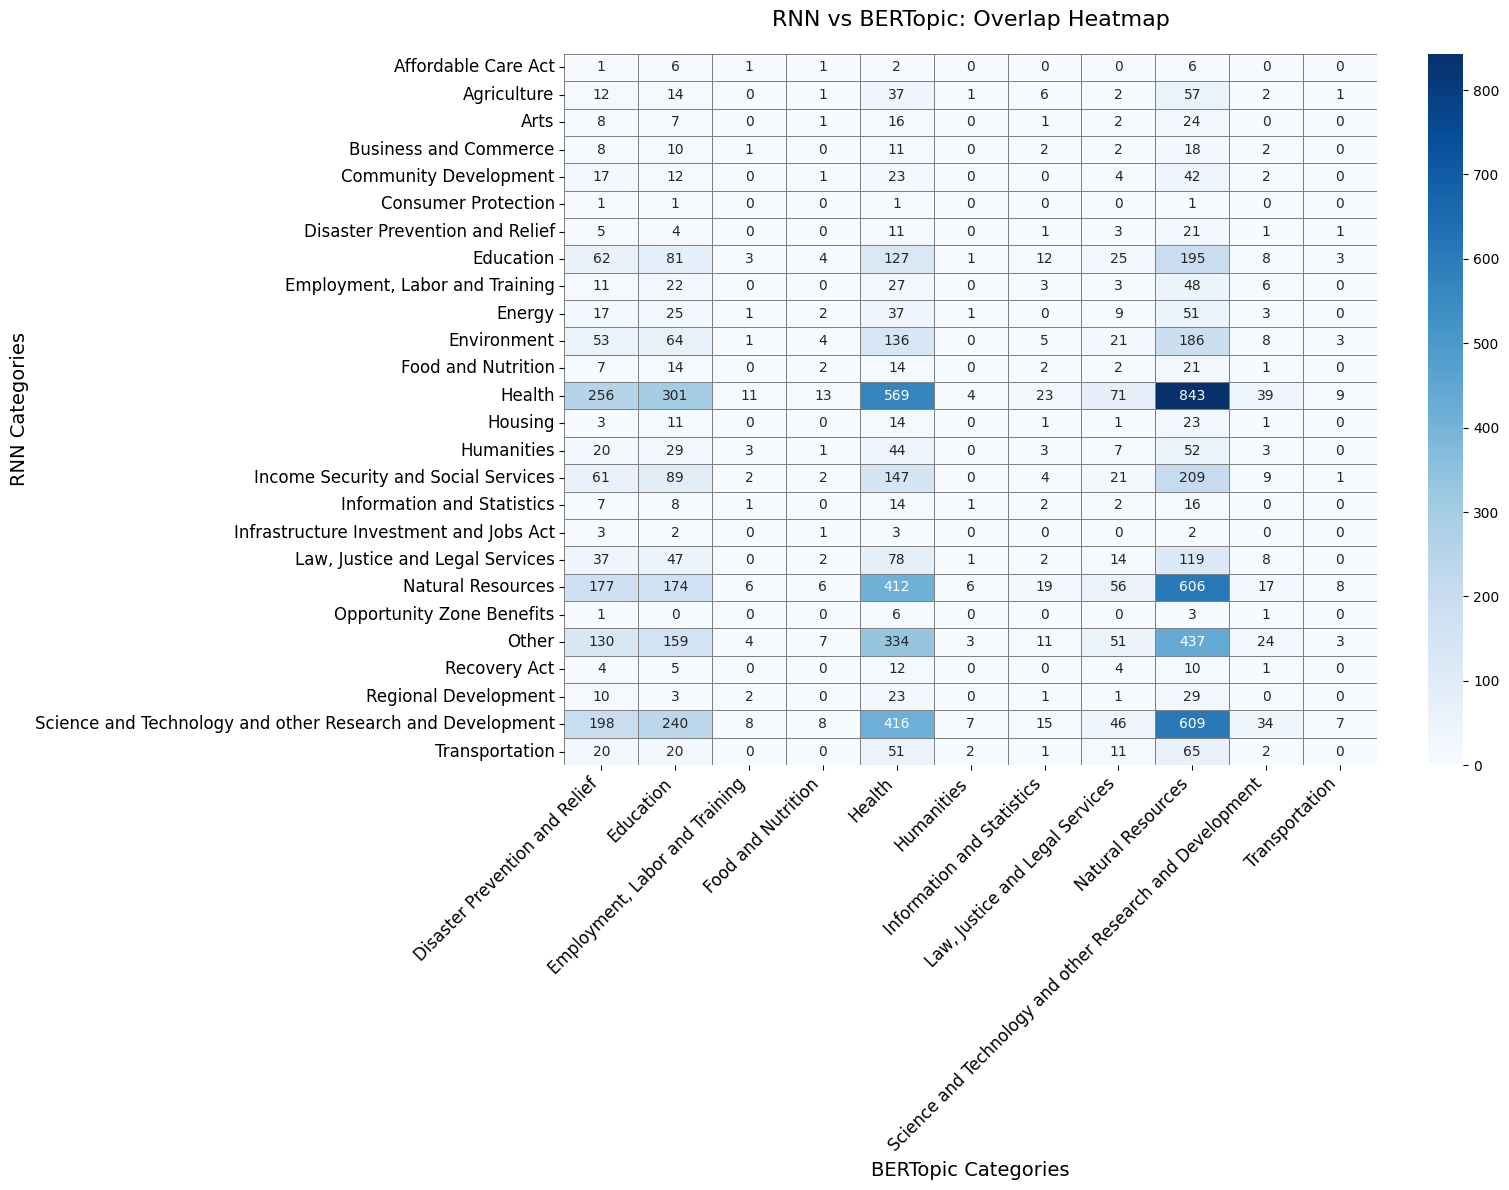

In [29]:
import seaborn as sns

# Align test set with RNN predictions- only working with test samples
test_indices = X_test.shape[0]
df_test = df.iloc[:test_indices].copy()

# Add RNN predictions to the dataframe
df_test['rnn_category'] = label_encoder.inverse_transform(y_test)

# Compare RNN predictions and BERTopic predictions
df_test['match'] = df_test['rnn_category'] == df_test['mapped_category']

# Count matches and mismatches
match_count = df_test['match'].sum()
mismatch_count = len(df_test) - match_count
print(f"Matching Predictions: {match_count}")
print(f"Mismatched Predictions: {mismatch_count}")

# Display examples of matches and mismatches
print("\nExamples of Matches:")
print(df_test[df_test['match']][['opportunity_title', 'rnn_category', 'mapped_category']].head())

print("\nExamples of Mismatches:")
print(df_test[~df_test['match']][['opportunity_title', 'rnn_category', 'mapped_category']].head())

# Analyze overlaps and mismatches per category
overlap_summary = df_test.groupby('rnn_category').apply(
    lambda group: {
        'total': len(group),
        'matches': group['match'].sum(),
        'mismatches': len(group) - group['match'].sum()
    }
).apply(pd.Series).reset_index()
overlap_summary.columns = ['Category', 'Total', 'Matches', 'Mismatches']
print("\nOverlap Summary by Category:")
print(overlap_summary)

# Create a cross-tabulation matrix of RNN and BERTopic predictions
overlap_matrix = pd.crosstab(df_test['rnn_category'], df_test['mapped_category'], rownames=['RNN'], colnames=['BERTopic'])

# Plot the heatmap
plt.figure(figsize=(16, 12))  # Increase figure size for better readability
sns.heatmap(
    overlap_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    linewidths=0.5,
    linecolor='gray'  # Add gridlines
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels by 45 degrees with larger font size
plt.yticks(fontsize=12)  # Increase y-axis font size

# Add title and axis labels
plt.title('RNN vs BERTopic: Overlap Heatmap', fontsize=16, pad=20)  # Add padding for title
plt.xlabel('BERTopic Categories', fontsize=14)
plt.ylabel('RNN Categories', fontsize=14)

# Adjust layout to ensure labels and title fit properly
plt.tight_layout()

# Display the heatmap
plt.show()


In [30]:
# Load BERTopic model if not already loaded
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load the saved BERTopic model
topic_model = BERTopic.load("bertopic_model")

# New sample titles for prediction
sample_titles = [
    "Improving healthcare access in rural areas",
    "Climate resilience research funding",
    "Educational opportunities for underprivileged youth",
    "Research on renewable energy technologies",
    "Community safety and crime prevention programs",
    "Innovations in agricultural practices",
    "Advancements in artificial intelligence",
    "Support for small business development",
    "Ocean and marine life conservation projects",
    "Healthcare innovations for low-income communities"
]

# Preprocess new sample titles
def preprocess_text(text):
    custom_stopwords = set(["grant", "funding", "application"])
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)
    return ' '.join([word for word in text.split() if word.lower() not in stopwords])

preprocessed_titles = [preprocess_text(title) for title in sample_titles]

# Predict topics for the new titles
topics, probs = topic_model.transform(preprocessed_titles)

# Map reduced topics to RNN categories
mapped_categories = {}
rnn_categories = label_encoder.classes_
category_embeddings = SentenceTransformer("all-MiniLM-L6-v2").encode(rnn_categories)

# Prepare embeddings for BERTopic topics
topic_keywords = []
for topic_id in range(len(topic_model.get_topic_info())):
    # Handle empty or undefined topics
    topic = topic_model.get_topic(topic_id)
    if topic:
        # Collect keywords if the topic is valid
        keywords = [word for word, _ in topic]
        topic_keywords.append(', '.join(keywords))
    else:
        topic_keywords.append('')

# Encode topic keywords
topic_embeddings = SentenceTransformer("all-MiniLM-L6-v2").encode(topic_keywords)

# Map reduced topics to RNN categories using cosine similarity
for topic_id, topic_embedding in enumerate(topic_embeddings):
    if topic_keywords[topic_id] != "":
        similarities = util.cos_sim(topic_embedding, category_embeddings).squeeze()
        best_match = similarities.argmax().item()
        mapped_categories[topic_id] = rnn_categories[best_match]
    else:
        mapped_categories[topic_id] = "Unknown"

# Predict categories for the new titles
predicted_categories = [mapped_categories.get(topic, "Unknown") for topic in topics]

# Display results
for title, category in zip(sample_titles, predicted_categories):
    print(f"Title: {title}\nPredicted Category: {category}\n")


Title: Improving healthcare access in rural areas
Predicted Category: Health

Title: Climate resilience research funding
Predicted Category: Unknown

Title: Educational opportunities for underprivileged youth
Predicted Category: Unknown

Title: Research on renewable energy technologies
Predicted Category: Science and Technology and other Research and Development

Title: Community safety and crime prevention programs
Predicted Category: Law, Justice and Legal Services

Title: Innovations in agricultural practices
Predicted Category: Food and Nutrition

Title: Advancements in artificial intelligence
Predicted Category: Science and Technology and other Research and Development

Title: Support for small business development
Predicted Category: Unknown

Title: Ocean and marine life conservation projects
Predicted Category: Natural Resources

Title: Healthcare innovations for low-income communities
Predicted Category: Health

